# **Import các thư viện**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
import torch.optim as optim

# **Import dữ liệu và tiền xử lý**


In [10]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('TSLA_data.csv')
df

,Date,Close,High,Low,Open,Volume,Change %
0,1/2/2018,21.368668,21.474001,20.733334,20.799999,65283000,0.028846
1,1/3/2018,21.150000,21.683332,21.036667,21.400000,67822500,-0.025327
2,1/4/2018,20.974667,21.236668,20.378668,20.858000,149194500,0.011986
3,1/5/2018,21.105333,21.149332,20.799999,21.108000,68868000,-0.001958
4,1/8/2018,22.427334,22.468000,21.033333,21.066668,147891000,0.060633
...,...,...,...,...,...,...,...
1830,4/14/2025,252.350006,261.799988,245.929993,258.359985,100135200,-0.032706
1831,4/15/2025,254.110001,258.750000,247.539993,249.910004,79594300,-0.009203
1832,4/16/2025,241.550003,251.970001,233.889999,247.610001,112378700,-0.016720
1833,4/17/2025,241.369995,244.339996,237.679993,243.470001,83404800,-0.054257


In [11]:
df1=df.reset_index()['Close']
df1.head()

,Close
0,21.368668
1,21.150000
2,20.974667
3,21.105333
4,22.427334


In [12]:
df1

,Close
0,21.368668
1,21.150000
2,20.974667
3,21.105333
4,22.427334
...,...
1830,252.350006
1831,254.110001
1832,241.550003
1833,241.369995


In [13]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [14]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [15]:
test_size

367

In [16]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [17]:
# # 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, y_test = create_dataset(test_data, time_step)

In [18]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100

x, y = create_dataset(df1, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
y_test = y[train_size-100:]

In [19]:
X_train.shape

(1368, 100)

# **Tạo Dataset cho PyTorch**

Để có thể áp dụng vào model ResNet

In [20]:
# Tạo Dataset cho PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.float32)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# **Mô hình ResNET**

In [21]:
# Định nghĩa mô hình ResNet
class ConvBlock(Module):
    def __init__(self, ni, nf, ks, stride=1, act=nn.ReLU, act_kwargs={}):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, stride=stride, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act(**act_kwargs) if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3]):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None)

        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1, act=None)
        self.add = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x + self.shortcut(res))
        x = self.act(x)
        return x

class ResNet(Module):
    def __init__(self, c_in, c_out, nf=64, kss=[7, 5, 3]):
        super().__init__()
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(nf * 2, c_out)

    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.global_avg_pool(x).squeeze(-1)  # Global Average Pooling to (batch, channels)
        x = self.fc(x)
        return x

In [22]:
# Khởi tạo mô hình
model = ResNet(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')

Epoch 1/100, Loss: 0.144243523478508, Test Loss: 0.0931554149525861
Epoch 2/100, Loss: 0.005517020355910063, Test Loss: 0.030006145127117634
Epoch 3/100, Loss: 0.0026232432574033737, Test Loss: 0.009813830760928491
Epoch 4/100, Loss: 0.019649242982268333, Test Loss: 0.0054554934419381125
Epoch 5/100, Loss: 0.029527412727475166, Test Loss: 0.0091705695570757
Epoch 6/100, Loss: 0.003441575448960066, Test Loss: 0.0038749100058339536
Epoch 7/100, Loss: 0.003931684419512749, Test Loss: 0.003299318787564213
Epoch 8/100, Loss: 0.00195134652312845, Test Loss: 0.0019959294295404106
Epoch 9/100, Loss: 0.005414105486124754, Test Loss: 0.0031794580281712115
Epoch 10/100, Loss: 0.010062700137495995, Test Loss: 0.005405620012121896
Epoch 11/100, Loss: 0.02569577656686306, Test Loss: 0.00525304988938539
Epoch 12/100, Loss: 0.007713508326560259, Test Loss: 0.005537355861937006
Epoch 13/100, Loss: 0.002288914518430829, Test Loss: 0.0014015048557970051
Epoch 14/100, Loss: 0.008147479966282845, Test Loss

# **Predict**

In [24]:
# Dự báo dữ liệu test
model.eval()
train_predict = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_predict.extend(outputs.squeeze().numpy())

test_predict = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predict.extend(outputs.squeeze().numpy())

train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))


In [25]:
# Dự báo 30 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output = []

for i in range(30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output.extend(yhat.detach().numpy().tolist())

lst_output = scaler.inverse_transform(lst_output)

In [26]:
# Dự báo 60 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_60 = []

for i in range(60):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_60.extend(yhat.detach().numpy().tolist())

lst_output_60 = scaler.inverse_transform(lst_output_60)

In [27]:
# Dự báo 90 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_90 = []

for i in range(90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_90.extend(yhat.detach().numpy().tolist())

lst_output_90 = scaler.inverse_transform(lst_output_90)

# **Các độ đo**

In [28]:
# Các độ đo
import numpy as np

# Mean Absolute Error
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Mean Squared Error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Root Mean Squared Error
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Mean Absolute Scaled Error
def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    errors = np.abs(y_true - y_pred)
    return np.mean(errors / d)

In [29]:
# Giá trị thực tế của tập huấn luyện và tập kiểm tra
y_train2 = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính độ đo cho tập kiểm tra
test_mae = mae(y_test2, test_predict)
test_mape = mape(y_test2, test_predict)
test_mase = mase(y_test2, test_predict, y_train)
test_mse = mse(y_test2, test_predict)
test_rmse = rmse(y_test2, test_predict)

print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f}%')
print(f'Test MASE: {test_mase:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Test MAE: 24.8383
Test MAPE: 8.7462%
Test MASE: 2651.4954
Test MSE: 1253.6210
Test RMSE: 35.4065


# **Vẽ hình**

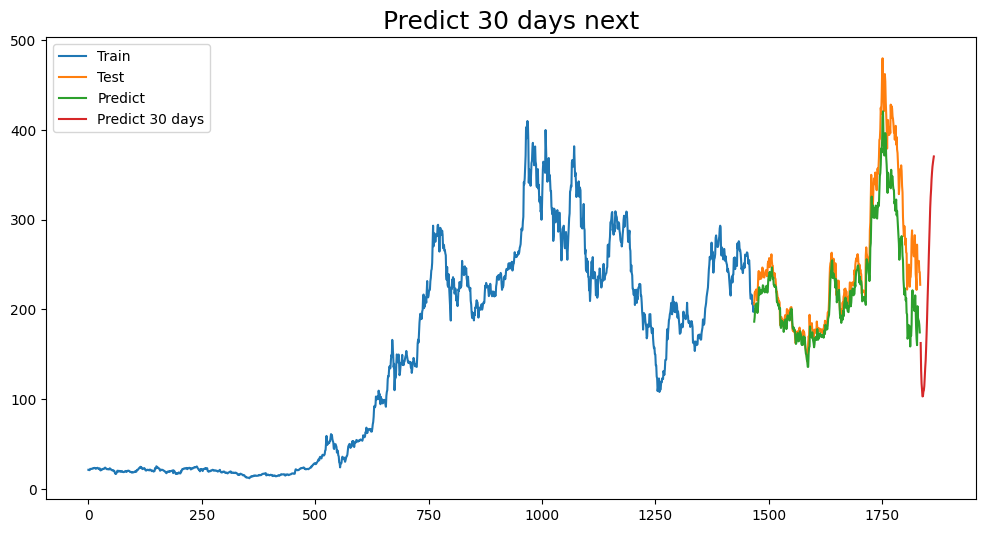

In [30]:
# Vẽ hình
plt.figure(figsize=(12, 6))
plt.title("Predict 30 days next", fontsize=18)
train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step - 100, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index = np.arange(len(df1), len(df1) + 30)
plt.plot(future_data_index, lst_output, label='Predict 30 days')

plt.legend()
plt.show()

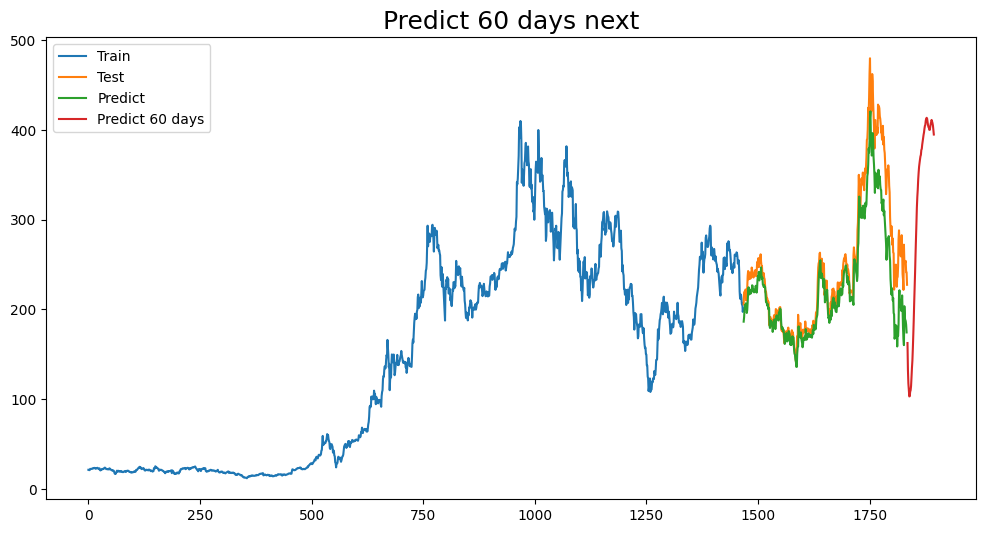

In [31]:
# Vẽ hình
plt.figure(figsize=(12, 6))
plt.title("Predict 60 days next", fontsize=18)
train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step - 100, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_60 = np.arange(len(df1), len(df1) + 60)
plt.plot(future_data_index_60, lst_output_60, label='Predict 60 days')

plt.legend()
plt.show()

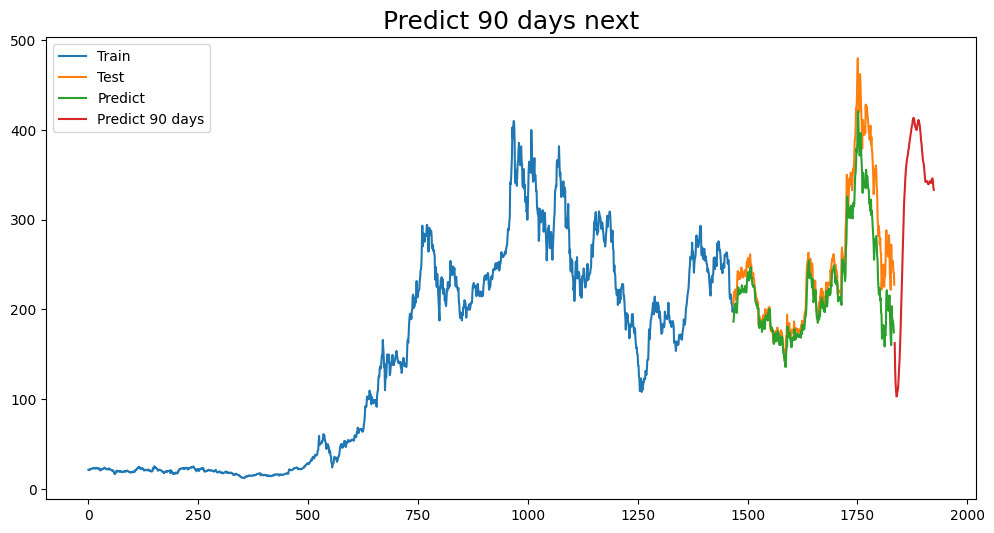

In [32]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step - 100, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

plt.legend()
plt.show()


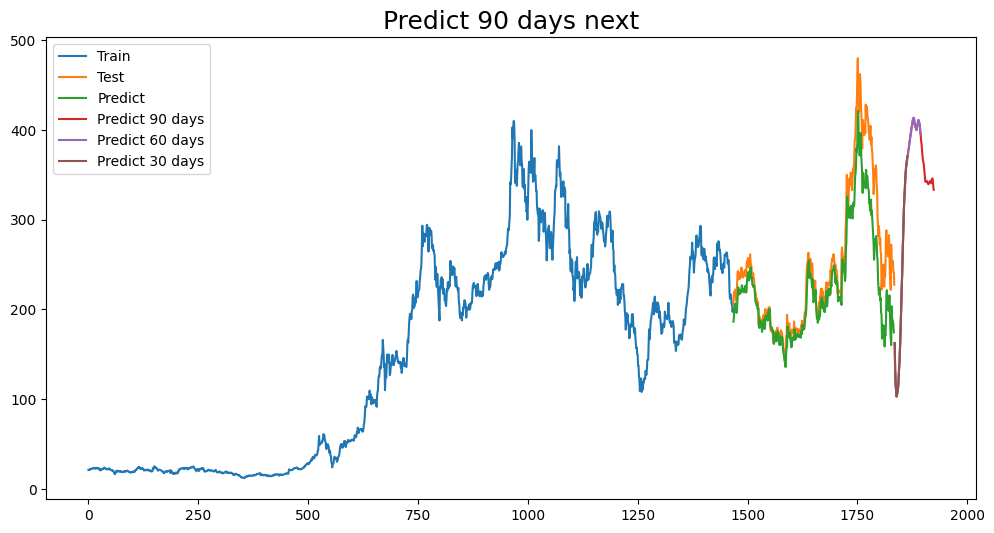

In [33]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step - 100, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

future_data_index_60 = np.arange(len(df1), len(df1) + 60)
plt.plot(future_data_index_60, lst_output_60, label='Predict 60 days')


future_data_index = np.arange(len(df1), len(df1) + 30)
plt.plot(future_data_index, lst_output, label='Predict 30 days')

plt.legend()
plt.show()

# **Mô hình ResnetLSTM**

In [34]:
# Định nghĩa mô hình ResNetLSTM
class ConvBlock(Module):
    def __init__(self, ni, nf, ks, stride=1, act=nn.ReLU, act_kwargs={}):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, stride=stride, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act(**act_kwargs) if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3]):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None)

        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1, act=None)
        self.add = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x + self.shortcut(res))
        x = self.act(x)
        return x

class ResNetLSTM(Module):
    def __init__(self, c_in, c_out, lstm_hidden_units=50, num_lstm_layers=1):
        super().__init__()
        nf = 64
        kss = [7, 5, 3]
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)

        self.lstm = nn.LSTM(nf * 2, lstm_hidden_units, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, c_out)

    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = x.transpose(1, 2)  # Transpose for LSTM: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Lấy đầu ra của LSTM ở bước thời gian cuối cùng
        x = self.fc(x)
        return x

In [35]:
# Khởi tạo mô hình
model2 = ResNetLSTM(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [36]:
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    model2.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    model2.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model2(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')

Epoch 1/100, Loss: 0.21592342853546143, Test Loss: 0.19339252760012945
Epoch 2/100, Loss: 0.04639896750450134, Test Loss: 0.04976158868521452
Epoch 3/100, Loss: 0.004490912891924381, Test Loss: 0.006125610942641894
Epoch 4/100, Loss: 0.0015089805237948895, Test Loss: 0.0023181058932095766
Epoch 5/100, Loss: 0.001768047222867608, Test Loss: 0.0019030165422009304
Epoch 6/100, Loss: 0.0015733267646282911, Test Loss: 0.0018194861089189847
Epoch 7/100, Loss: 0.0013947318075224757, Test Loss: 0.0018261150786808382
Epoch 8/100, Loss: 0.0014789976412430406, Test Loss: 0.0021123070813094578
Epoch 9/100, Loss: 0.0014869329752400517, Test Loss: 0.001869566593086347
Epoch 10/100, Loss: 0.0026110310573130846, Test Loss: 0.002159919880796224
Epoch 11/100, Loss: 0.0013978596543893218, Test Loss: 0.0018476285719467949
Epoch 12/100, Loss: 0.0012238657800480723, Test Loss: 0.001905090156166504
Epoch 13/100, Loss: 0.0019708804320544004, Test Loss: 0.0018023345328401774
Epoch 14/100, Loss: 0.0014403574168

In [37]:
# Dự báo dữ liệu test
model2.eval()
train_predict = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model2(inputs)
        train_predict.extend(outputs.squeeze().numpy())

test_predict = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model2(inputs)
        test_predict.extend(outputs.squeeze().numpy())

train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))

In [38]:
# Giá trị thực tế của tập huấn luyện và tập kiểm tra
y_train2 = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính độ đo cho tập kiểm tra
test_mae = mae(y_test2, test_predict)
test_mape = mape(y_test2, test_predict)
test_mase = mase(y_test2, test_predict, y_train)
test_mse = mse(y_test2, test_predict)
test_rmse = rmse(y_test2, test_predict)

print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f}%')
print(f'Test MASE: {test_mase:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Test MAE: 23.3139
Test MAPE: 7.7512%
Test MASE: 2488.7656
Test MSE: 1254.4014
Test RMSE: 35.4175


In [39]:
# Dự báo 90 ngày tiếp theo
model2.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_90 = []

for i in range(90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_90.extend(yhat.detach().numpy().tolist())

lst_output_90 = scaler.inverse_transform(lst_output_90)

In [40]:
# Dự báo 60 ngày tiếp theo
model2.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_60 = []

for i in range(60):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_60.extend(yhat.detach().numpy().tolist())

lst_output_60 = scaler.inverse_transform(lst_output_60)

In [41]:
# Dự báo 30 ngày tiếp theo
model2.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_30 = []

for i in range(30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_30.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_30.extend(yhat.detach().numpy().tolist())

lst_output_30 = scaler.inverse_transform(lst_output_30)

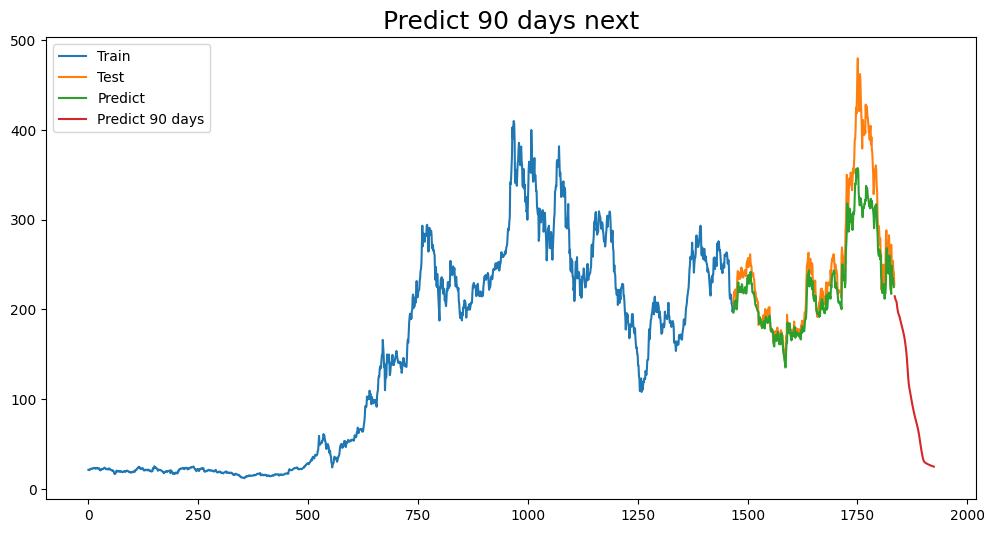

In [42]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step - 100, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

plt.legend()
plt.show()

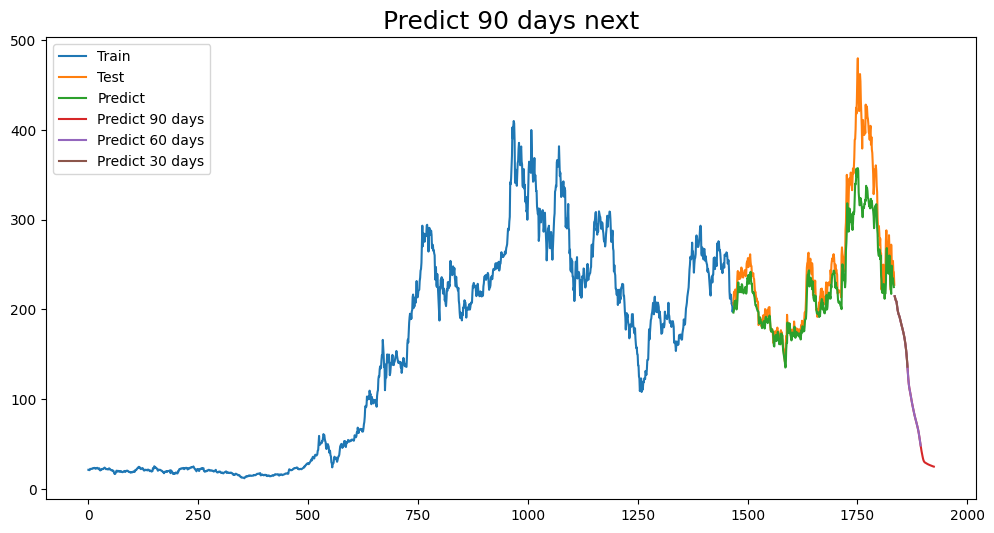

In [43]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step - 100, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

future_data_index_60 = np.arange(len(df1), len(df1) + 60)
plt.plot(future_data_index_60, lst_output_60, label='Predict 60 days')


future_data_index30 = np.arange(len(df1), len(df1) + 30)
plt.plot(future_data_index30, lst_output_30, label='Predict 30 days')

plt.legend()
plt.show()